In [86]:
# 库文件
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from skopt import gp_minimize
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
# 库文件
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from skopt import gp_minimize
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import train_test_split

import numpy as np
from scipy.optimize import minimize
from sklearn.metrics.pairwise import rbf_kernel
import optuna

import numpy as np
from sklearn.svm import SVR
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd


import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import train_test_split

import numpy as np
from scipy.optimize import minimize
from sklearn.metrics.pairwise import rbf_kernel


import numpy as np
from sklearn.svm import SVR
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd
# 库文件
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
# 设置中文字体
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)  # 替换为你的中文字体文件路径

from itertools import chain



Index(['主参数时间戳', '热风压力', '热风温度', '富氧率', '喷煤量', 'Unnamed: 5', '鼓风湿度',
       'Unnamed: 7', '炉腹煤气量', 'si'],
      dtype='object')


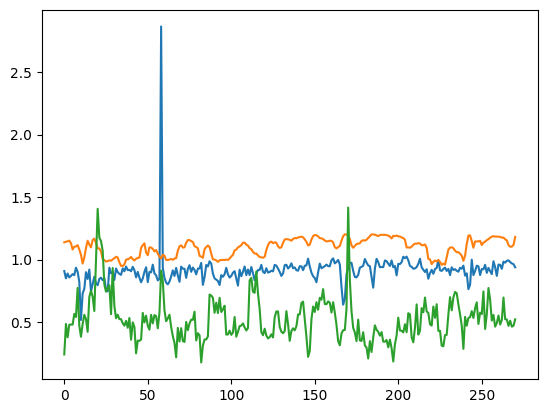

In [161]:
# 从 Excel 文件读取数据
excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据\\论文数据.xlsx'
df_sheet = pd.read_excel(excel_path)
print(df_sheet.columns)
# 提取列数据
u1_data = (df_sheet['热风压力'].values-0.3)*10
u2_data = (df_sheet['热风温度'].values-4)/1000
# u3_data = (df_sheet['富氧率'].values-4)*1
# u4_data = (df_sheet['喷煤量'].values-4)*1
y1_data = (df_sheet['si'].values)*1

# # 输出提取的数据
# print('u1_data:', u1_data.shape)
# print('u2_data:', u2_data.shape)
# print('y1_data:', y1_data.shape)
# print('y2_data:', y1_data.shape)

num_samples = y1_data.shape[0]


plt.plot(u1_data)
plt.plot(u2_data)
# plt.plot(u3_data)
# plt.plot(u4_data)
plt.plot(y1_data)


In [167]:
# 组合训练数据  多输入单输出
# 假设有训练数据 u1_data, u2_data, y1_data 和 y1_data+1
# 将它们组合成输入特征矩阵 X 和输出标签向量 y
u1_data = u1_data
u2_data = u2_data

u1_data_1 = np.roll(u1_data, 1)
u2_data_1 = np.roll(u2_data, 1)
u1_data_1[0], u2_data_1[0] = 0, 0

y1_data = y1_data

X = np.column_stack((u1_data[:-1], u2_data[:-1], u1_data_1[:-1], u2_data_1[:-1], y1_data[:-1]))
y = y1_data[1:]

print(X.shape,y.shape)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33333, 
                                                    random_state=42,
                                                    shuffle= False
                                                )


(270, 5) (270,)


In [168]:
# 定义My_LS_SVRModel
class My_LS_SVRModel:
    def __init__(self, params):
        self.C = params[0]
        self.gamma = params[1]
        self.W_b = None
        self.X_train = None

    def model_train(self, X_train, y_train, K_train):
        def objective(W_b, X, y, C):
            y_pred = np.dot(K_train, W_b[:-1]) + W_b[-1]
            errors = y - y_pred
            loss = 0.5 * np.dot(W_b[:-1], W_b[:-1]) + C * np.sum(errors**2)
            return loss

        initial_W_b = np.zeros(X_train.shape[0] + 1)
        result = minimize(objective, initial_W_b, args=(X_train, y_train, self.C), method='L-BFGS-B')
        best_W_b = result.x
        return best_W_b

    def fit(self, X_train, y_train):
        self.X_train = X_train
        K_train = rbf_kernel(X_train, X_train, gamma=self.gamma)
        self.W_b = self.model_train(X_train, y_train, K_train)

    def predict(self, X_test):
        K_test = rbf_kernel(X_test, self.X_train, gamma=self.gamma)
        y_pred = np.dot(K_test, self.W_b[:-1]) + self.W_b[-1]
        return y_pred
    

# # 示例用法
# params = [8.78525340e+01, 2.01347249e-03]
# # 创建模型
# my_svr_model = My_LS_SVRModel(params=params)
# # 训练模型
# my_svr_model.fit(X_train, y_train)
# # 模型预测
# y_pred = my_svr_model.predict(X_test)


In [169]:
def your_fitness_function(trial, params, X_train, y_train, X_test, y_test):
    # 示例用法
    # 创建模型
    my_svr_model = My_LS_SVRModel(params=params)
    # 训练模型
    my_svr_model.fit(X_train, y_train)
    # 模型预测
    y_pred = my_svr_model.predict(X_test)        
    # 在这里计算适应值（均方根误差）
    errors = y_test - y_pred
    mse = np.sqrt(np.sum(errors**2)/X_test.shape[0])

    return mse


# 目标函数适配 Optuna 风格
def objective(trial, X_train, y_train, X_test, y_test):
    # 在搜索空间中定义超参数
    C = trial.suggest_float('C', 0.1, 20.0, log=True)
    gamma = trial.suggest_float('gamma', 1e-9, 10, log=True)

    # 调用你的目标函数
    params = [C, gamma]
    mse = your_fitness_function(trial, params, X_train, y_train, X_test, y_test)
    
    # 返回目标值（Optuna 默认是最小化目标）
    return mse

# 创建 Optuna 试验对象
study = optuna.create_study(direction='minimize')

# 执行优化
study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), 
            n_trials = 10)


# 输出结果
print(f"Best Trial: {study.best_trial.params}")
print(f"Best MSE: {study.best_value}")




[I 2024-01-24 18:32:36,015] A new study created in memory with name: no-name-b0ead27c-8a19-4ab4-b97f-9346d8da5d76
[I 2024-01-24 18:32:36,071] Trial 0 finished with value: 0.13555243963968225 and parameters: {'C': 4.82341341267751, 'gamma': 2.427789461766903e-09}. Best is trial 0 with value: 0.13555243963968225.
[I 2024-01-24 18:32:36,331] Trial 1 finished with value: 0.10758996651391248 and parameters: {'C': 7.099279200907553, 'gamma': 0.02218288642259841}. Best is trial 1 with value: 0.10758996651391248.
[I 2024-01-24 18:32:36,953] Trial 2 finished with value: 0.10425246243504847 and parameters: {'C': 3.279154248117342, 'gamma': 0.7116307772134264}. Best is trial 2 with value: 0.10425246243504847.
[I 2024-01-24 18:32:37,023] Trial 3 finished with value: 0.13555187690635617 and parameters: {'C': 1.4291472192962644, 'gamma': 3.370798304489383e-08}. Best is trial 2 with value: 0.10425246243504847.
[I 2024-01-24 18:32:37,206] Trial 4 finished with value: 0.09919343325005402 and parameters

Best Trial: {'C': 2.6937585264508606, 'gamma': 0.122376487972309}
Best MSE: 0.09919343325005402


In [170]:
# 创建模型
#  data    [5.33702937e+01 2.46106482e-02]  0.29159782217670577
#  data2   [3.04694015e+01 2.11002630e-02]  0.3105070871640635
# params =  [1,1]
params = [study.best_trial.params['C'],study.best_trial.params['gamma']]
# params = result_position
my_svr_model = My_LS_SVRModel(params=params)
# 训练模型
my_svr_model.fit(X_train, y_train)
# 模型预测
y_pred_0 = my_svr_model.predict(X_test)


RMSE: SI: 0.0992
MRE : SI: 0.1803
MAPE: SI: 18.0308%
MAE:0.0784,RMSE:0.2800,HR:0.6667,RE:0.0383


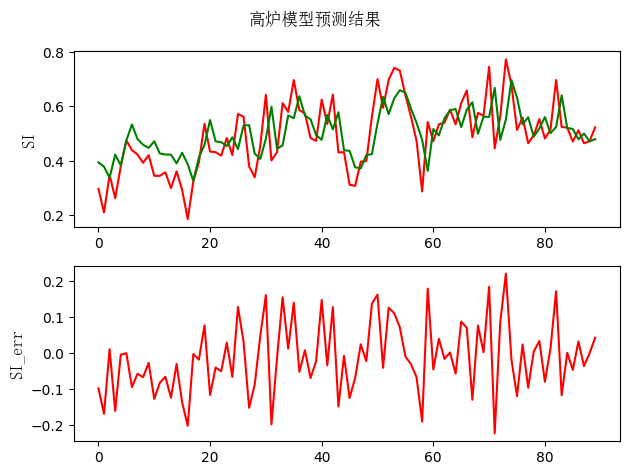

In [171]:
# 计算 RMSE、MRE
y_test = y_test

# y_test = y_test[:-1]
# y_pred_0 = y_pred_0[1:]
output_term = ['SI']
y_test_0 = y_test
y_pred_0_inverse_transform = y_pred_0
rmse_0 = np.sqrt(mean_squared_error(y_test_0, y_pred_0_inverse_transform))

# 计算 
mre_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0))

# 打印结果
print(f"RMSE: {output_term[0]}: {rmse_0:.4f}")
print(f"MRE : {output_term[0]}: { mre_0:.4f}")
mape_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0)) * 100
print(f"MAPE: {output_term[0]}: {mape_0:.4f}%")



output0 = y_test_0 - y_pred_0_inverse_transform
MAE = np.mean(np.abs(output0))
RMSE = np.sqrt(MAE)
HR = np.sum(np.abs(output0)<0.1)/len(output0)
RE = np.sum(output0**2)/np.sum(y_test**2)
print(f'MAE:{MAE:.4f},RMSE:{RMSE:.4f},HR:{HR:.4f},RE:{RE:.4f}')

plt.subplot(2, 1, 1)
plt.plot(y_test_0,'r')
plt.plot(y_pred_0_inverse_transform,'g')
plt.ylabel(output_term[0], fontproperties=font)  # 使用中文标签



plt.subplot(2, 1, 2)
plt.plot(output0,'r-')
plt.ylabel(output_term[0]+'_err', fontproperties=font)  # 使用中文标签
plt.suptitle('高炉模型预测结果', fontproperties=font)  # 添加整个图形的标题
plt.tight_layout()
plt.show()



